In [2]:
from elasticsearch import Elasticsearch
from collections import Counter, defaultdict
import pandas as pd
import pyupset as pyu
import re
import itertools
import json
from IPython.display import set_matplotlib_formats

%matplotlib inline

In [3]:
es = Elasticsearch(['elastic:9200'])
es

<Elasticsearch([{u'host': u'elastic', u'port': 9200}])>

In [4]:
res = es.search(index="associations",
                _source_exclude=['cgi', 'jax', 'civic', 'sage', 'molecularmatch_trials',
                                 'molecularmatch', 'oncokb', 'pmkb', 'jax_trials', 'brca'],
                size=10000, body={"query": {"match_all": {}}})
print res['hits']['total']

63169


In [6]:
def collect_all_results():
    res = es.search(index="associations", size=10000, body={"query": {"match_all": {}}}, scroll='1m',
                    _source_exclude=['cgi', 'jax', 'civic', 'sage', 'molecularmatch_trials',
                                 'molecularmatch', 'oncokb', 'pmkb', 'jax_trials', 'brca']
                   )
    scroll_id = res.get('_scroll_id')
    i = 1
    scroll_size = res['hits']['total']

    while scroll_size > 0:
        print('Processing scroll {}'.format(i))
        r = es.scroll(scroll_id, scroll='1m')
        scroll_id = r.get('_scroll_id')
        res['hits']['hits'] += r['hits']['hits']
        i += 1
        scroll_size = len(r['hits']['hits'])
    return res

res = collect_all_results() 

Processing scroll 1
Processing scroll 2
Processing scroll 3
Processing scroll 4
Processing scroll 5
Processing scroll 6
Processing scroll 7


# Total Associations

In [7]:
assert len(res['hits']['hits']) == res['hits']['total']
len(res['hits']['hits'])

63169

In [8]:
def count_attribute(result, attribute):
    c = Counter([x['_source'][attribute] for x in result['hits']['hits']])
    return c

def count_attribute_by_group(result, attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([x['_source'][attribute] for x in result['hits']['hits'] if x['_source'][group] == g])
    return d

def count_list_attribute(result, list_attribute):
    c = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute]])
    return c

def count_list_attribute_by_group(result, list_attribute, group):
    d = dict()
    for g in count_attribute(result, group):
        d[g] = Counter([attribute for x in result['hits']['hits'] for attribute in x['_source'][list_attribute] if x['_source'][group] == g])
    return d

In [9]:
count_attribute(res, 'source')

Counter({u'brca': 5733,
         u'cgi': 1431,
         u'civic': 3176,
         u'jax': 3649,
         u'jax_trials': 1131,
         u'molecularmatch': 2079,
         u'molecularmatch_trials': 41143,
         u'oncokb': 4149,
         u'pmkb': 609,
         u'sage': 69})

# Genes

In [10]:
%%capture
count_list_attribute(res, 'genes')

In [11]:
d = count_list_attribute_by_group(res, 'genes', 'source')

CGI has some genotype "genes" (e.g. 'ARID1A;ANXA1' from ARID1A amplification + ANXA1 overexpression)

CKB have some multi-gene molecular profiles. Example: https://ckb.jax.org/molecularProfile/show/26172

In [12]:
multi_gene_hits = [x for x in res['hits']['hits'] if len(x['_source']['genes']) >= 2]
s = Counter([x['_source']['source'] for x in multi_gene_hits])
s

Counter({u'cgi': 44,
         u'jax': 3547,
         u'jax_trials': 314,
         u'molecularmatch': 17,
         u'molecularmatch_trials': 17618})

In [13]:
mp_d = dict()
for source in s:
    mp_d[source] = set([tuple(sorted(x['_source']['genes'])) for x in res['hits']['hits'] if (len(x['_source']['genes']) >= 2) and (x['_source']['source'] == source)])

In [14]:
%%capture
mp_d

In [15]:
def overlap(group_counts):
    columns = sorted(group_counts) + ['Total']
    sets = {g: set(group_counts[g]) for g in group_counts}
    for g in sets:
        total = set()
        for s in sets:
            l = len(sets[g])
            if s != g:
                o = (sets[g] & sets[s])
                total |= sets[s]
            else:
                continue
            print('{} has {}/{} ({:.2f}%) overlap with {}'.format(g, len(o), l, len(o) / l * 100, s))
        o = (sets[g] & total)
        print('{} has {}/{} ({:.2f}%) overlap overall'.format(g, len(o), l, len(o) / l * 100, s))

In [16]:
overlap(d)

cgi has 0/183 (0.00%) overlap with jax
cgi has 122/183 (0.00%) overlap with civic
cgi has 2/183 (0.00%) overlap with sage
cgi has 155/183 (0.00%) overlap with molecularmatch_trials
cgi has 61/183 (0.00%) overlap with molecularmatch
cgi has 132/183 (0.00%) overlap with oncokb
cgi has 38/183 (0.00%) overlap with pmkb
cgi has 46/183 (0.00%) overlap with jax_trials
cgi has 2/183 (0.00%) overlap with brca
cgi has 169/183 (0.00%) overlap overall
jax has 0/33 (0.00%) overlap with cgi
jax has 0/33 (0.00%) overlap with civic
jax has 0/33 (0.00%) overlap with sage
jax has 0/33 (0.00%) overlap with molecularmatch_trials
jax has 0/33 (0.00%) overlap with molecularmatch
jax has 0/33 (0.00%) overlap with oncokb
jax has 0/33 (0.00%) overlap with pmkb
jax has 0/33 (0.00%) overlap with jax_trials
jax has 0/33 (0.00%) overlap with brca
jax has 0/33 (0.00%) overlap overall
civic has 122/292 (0.00%) overlap with cgi
civic has 0/292 (0.00%) overlap with jax
civic has 2/292 (0.00%) overlap with sage
civic h

In [17]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g].keys()), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = ['attribute'])

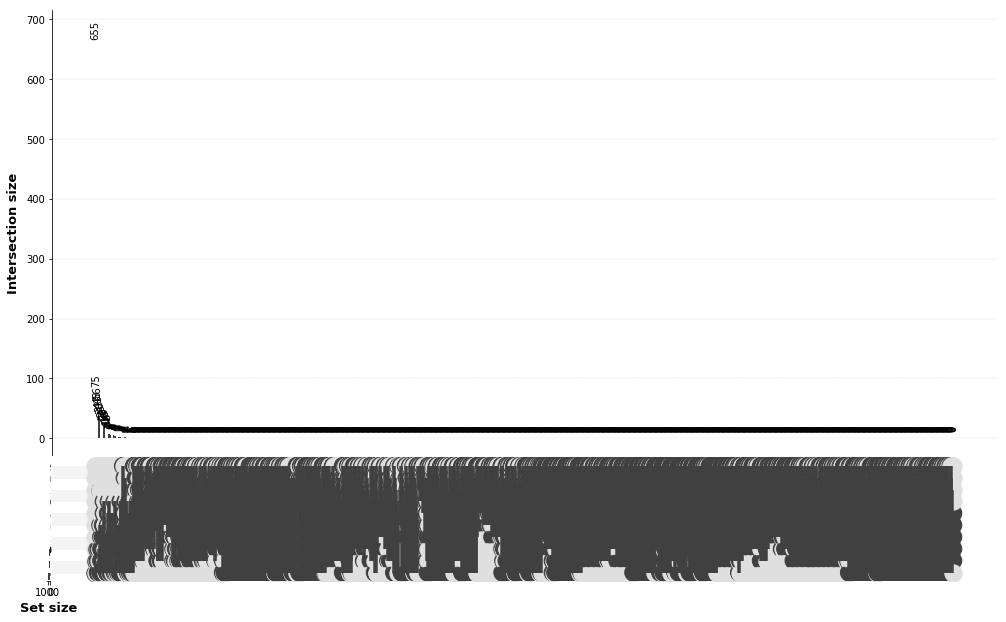

In [18]:
plot_overlap(d)

# Overlap of associations (drug + gene + phenotype)

Some hits (example here is from CGI) have strange behavior on drug normalization:

In [19]:
res['hits']['hits'][0]['_source']['association']['environmentalContexts']

[{u'approved_countries': [u'Canada', u'US'],
  u'description': u'CRIZOTINIB',
  u'id': u'compound:CID11626560',
  u'taxonomy': {u'class': u'Pyridines and derivatives',
   u'direct-parent': u'Pyrazolylpyridines',
   u'kingdom': u'Organic compounds',
   u'subclass': u'Pyrazolylpyridines',
   u'superclass': u'Organoheterocyclic compounds'},
  u'term': u'CRIZOTINIB',
  u'usan_stem': u'tyrosine kinase inhibitors'}]

"Inhibitor" drug: https://pubchem.ncbi.nlm.nih.gov/compound/diacylglycerol_kinase_inhibitor_ii#section=Top

In [22]:
# res['hits']['hits'][0]['_source']['cgi']

In [23]:
def select_failures(hits):
    pheno_failed = 0
    drug_failed = 0
    gene_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            print( "Gene failure on ID {}".format( hit['_id']))
            gene = None
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            print( "Drug failure on ID {}".format( hit['_id'] ))
            drug_failed += 1
            drug = None
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if gene is None or drug is None or phenotype is None:
            yield(hit)
        # yield (gene,drug,phenotype)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} hits with failed drug'.format(drug_failed))
    print('{} total hits'.format(len(hits)))

In [24]:
def failure_types_by_source(hits):
    failures = defaultdict(Counter)
    totals = Counter()
    for hit in hits:
        totals[hit['_source']['source']] += 1
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            failures[hit['_source']['source']]['gene'] += 1
        try:
            drug = '|'.join(sorted([x['id'] for x in hit['_source']['association']['environmentalContexts']]))
        except:
            failures[hit['_source']['source']]['drug'] += 1
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            failures[hit['_source']['source']]['phenotype'] += 1
    return failures, totals

In [25]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [26]:
print("{:.2f}% of associations not fully normalized across gene, drug, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

0.00% of associations not fully normalized across gene, drug, phenotype


In [27]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({u'cgi': 245,
         u'civic': 63,
         u'jax': 184,
         u'jax_trials': 38,
         u'molecularmatch': 32,
         u'molecularmatch_trials': 5745,
         u'oncokb': 40,
         u'pmkb': 609,
         u'sage': 10})

In [28]:
def percent(num, den):
    return "{:.2f}%".format(num / den * 100)

d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{u'cgi': '0.00%',
 u'civic': '0.00%',
 u'jax': '0.00%',
 u'jax_trials': '0.00%',
 u'molecularmatch': '0.00%',
 u'molecularmatch_trials': '0.00%',
 u'oncokb': '0.00%',
 u'pmkb': '100.00%',
 u'sage': '0.00%'}

In [29]:
failures = failure_types_by_source(res['hits']['hits'])
print('Drug failures:')
{source: percent(failures[0][source]['drug'], failures[1][source]) for source in failures[0]}

Drug failures:


{u'cgi': '0.00%',
 u'civic': '0.00%',
 u'jax': '0.00%',
 u'jax_trials': '0.00%',
 u'molecularmatch': '0.00%',
 u'molecularmatch_trials': '0.00%',
 u'oncokb': '0.00%',
 u'pmkb': '100.00%',
 u'sage': '0.00%'}

In [30]:
{source: percent(failures[0][source]['phenotype'], failures[1][source]) for source in failures[0]}

{u'cgi': '0.00%',
 u'civic': '0.00%',
 u'jax': '0.00%',
 u'jax_trials': '0.00%',
 u'molecularmatch': '0.00%',
 u'molecularmatch_trials': '0.00%',
 u'oncokb': '0.00%',
 u'pmkb': '0.00%',
 u'sage': '0.00%'}

PMKB interpretations (https://pmkb.weill.cornell.edu/therapies) do not list drugs.

In [31]:
pmkb = [x for x in failed if x['_source']['source'] == 'pmkb']
pmkb[0]['_source']['association']

{u'description': u'Mutations in beta catenin (CTNNB1) are seen in about 90% of adamantinomatous craniopharyngiomas and mutations in BRAF (V600E) in papillary craniopharyngiomas. Adamantinomatous and papillary craniopharyngiomas have been shown to carry clonal mutations that are mutually exclusive. These findings indicate that the adamantinomatous and papillary subtypes have distinct molecular underpinnings, each principally driven by mutations in a single well-established oncogene \u2013 CTNNB1 in the adamantinomatous form and BRAF in the papillary form, independent of age. This may have implications for the diagnosis and treatment of these tumors.',
 u'drug_labels': u'NA',
 u'evidence': [{u'description': u'2',
   u'evidenceType': {u'sourceName': u'pmkb'},
   u'info': {u'publications': [u'http://www.ncbi.nlm.nih.gov/pubmed/None']}}],
 u'evidence_label': u'C',
 u'evidence_level': 3,
 u'phenotype': {u'description': u'craniopharyngioma',
  u'family': u'nervous system benign neoplasm',
  u

In [32]:
any(['environmentalContexts' in x['_source']['association'] for x in pmkb])

False

# Overlap of associations (gene + phenotype)

In [33]:
def select_failures(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
        except:
            gene = ''
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            yield(hit)
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [34]:
%%capture
failed = list(select_failures(res['hits']['hits']))

In [35]:
print("{:.2f}% of associations not fully normalized across gene, phenotype".format(len(failed) / len(res['hits']['hits']) * 100))

0.00% of associations not fully normalized across gene, phenotype


In [36]:
c = Counter([x['_source']['source'] for x in failed])
c

Counter({u'cgi': 112,
         u'civic': 38,
         u'jax': 1,
         u'jax_trials': 5,
         u'molecularmatch': 1,
         u'molecularmatch_trials': 4197,
         u'oncokb': 16,
         u'pmkb': 51,
         u'sage': 3})

In [37]:
d = count_attribute(res, 'source')
{source: percent(c[source], d[source]) for source in c}

{u'cgi': '0.00%',
 u'civic': '0.00%',
 u'jax': '0.00%',
 u'jax_trials': '0.00%',
 u'molecularmatch': '0.00%',
 u'molecularmatch_trials': '0.00%',
 u'oncokb': '0.00%',
 u'pmkb': '0.00%',
 u'sage': '0.00%'}

Prostate Adenocarcinoma?

In [38]:
cgi = [x for x in failed if x['_source']['source'] == 'cgi']
cgi[0]['_source']['association']

{u'description': u'CSF1R Imatinib (BCR-ABL inhibitor 1st gen&KIT inhibitor) Responsive',
 u'drug_labels': u'Imatinib',
 u'environmentalContexts': [{u'approved_countries': [u'Canada', u'US'],
   u'description': u'Imatinib',
   u'id': u'compound:CID5291',
   u'taxonomy': {u'class': u'Benzenoids',
    u'direct-parent': u'Benzanilides',
    u'kingdom': u'Chemical entities',
    u'subclass': u'Benzene and substituted derivatives',
    u'superclass': u'Organic compounds'},
   u'term': u'Imatinib',
   u'toxicity': u'The most frequently reported adverse reactions (>30%) were edema, nausea,\r\nvomiting, muscle cramps, musculoskeletal pain, diarrhea, rash, fatigue and\r\nabdominal pain.',
   u'usan_stem': u'tyrosine kinase inhibitors'}],
 u'evidence': [{u'description': u'Responsive',
   u'evidenceType': {u'sourceName': u'cgi'},
   u'info': {u'publications': [u'http://www.ncbi.nlm.nih.gov/pubmed/18971950']}}],
 u'evidence_label': u'D',
 u'evidence_level': 4,
 u'phenotype': {u'description': u'Myel

In [40]:
# cgi[0]['_source']['cgi']

In [41]:
%%capture
set([x['_source']['association']['phenotype']['description'] for x in cgi])

In [42]:
def select_successes(hits):
    pheno_failed = 0
    for hit in hits:
        try:
            gene = '|'.join(sorted(hit['_source']['genes']))
            hit['merged'] = {'gene': gene}
        except:
            hit['merged'] = {'gene': ''}
        try:
            phenotype = hit['_source']['association']['phenotype']['type']['id']
        except:
            print( "Phenotype failure on ID {}".format( hit['_id'] ))
            pheno_failed += 1
            phenotype = None
        if phenotype is None:
            continue
        hit['merged']['phenotype'] = phenotype
        yield hit
        
    print('{} hits with failed phenotype'.format(pheno_failed))
    print('{} total hits'.format(len(hits)))

In [43]:
%%capture
successes = list(select_successes(res['hits']['hits']))

In [44]:
s = Counter([x['_source']['source'] for x in successes])
s

Counter({u'brca': 5733,
         u'cgi': 1319,
         u'civic': 3138,
         u'jax': 3648,
         u'jax_trials': 1126,
         u'molecularmatch': 2078,
         u'molecularmatch_trials': 36946,
         u'oncokb': 4133,
         u'pmkb': 558,
         u'sage': 66})

In [45]:
success_by_source = dict()
for source in s:
    success_by_source[source] = set([(x['merged']['gene'], x['merged']['phenotype']) for x in successes if x['_source']['source'] == source])

In [46]:
%%capture
success_by_source

In [47]:
overlap(success_by_source)

cgi has 0/374 (0.00%) overlap with jax
cgi has 90/374 (0.00%) overlap with civic
cgi has 10/374 (0.00%) overlap with sage
cgi has 90/374 (0.00%) overlap with molecularmatch_trials
cgi has 18/374 (0.00%) overlap with molecularmatch
cgi has 56/374 (0.00%) overlap with oncokb
cgi has 19/374 (0.00%) overlap with pmkb
cgi has 42/374 (0.00%) overlap with jax_trials
cgi has 0/374 (0.00%) overlap with brca
cgi has 169/374 (0.00%) overlap overall
jax has 0/528 (0.00%) overlap with cgi
jax has 0/528 (0.00%) overlap with civic
jax has 0/528 (0.00%) overlap with sage
jax has 0/528 (0.00%) overlap with molecularmatch_trials
jax has 0/528 (0.00%) overlap with molecularmatch
jax has 0/528 (0.00%) overlap with oncokb
jax has 0/528 (0.00%) overlap with pmkb
jax has 0/528 (0.00%) overlap with jax_trials
jax has 0/528 (0.00%) overlap with brca
jax has 0/528 (0.00%) overlap overall
civic has 90/788 (0.00%) overlap with cgi
civic has 0/788 (0.00%) overlap with jax
civic has 5/788 (0.00%) overlap with sage


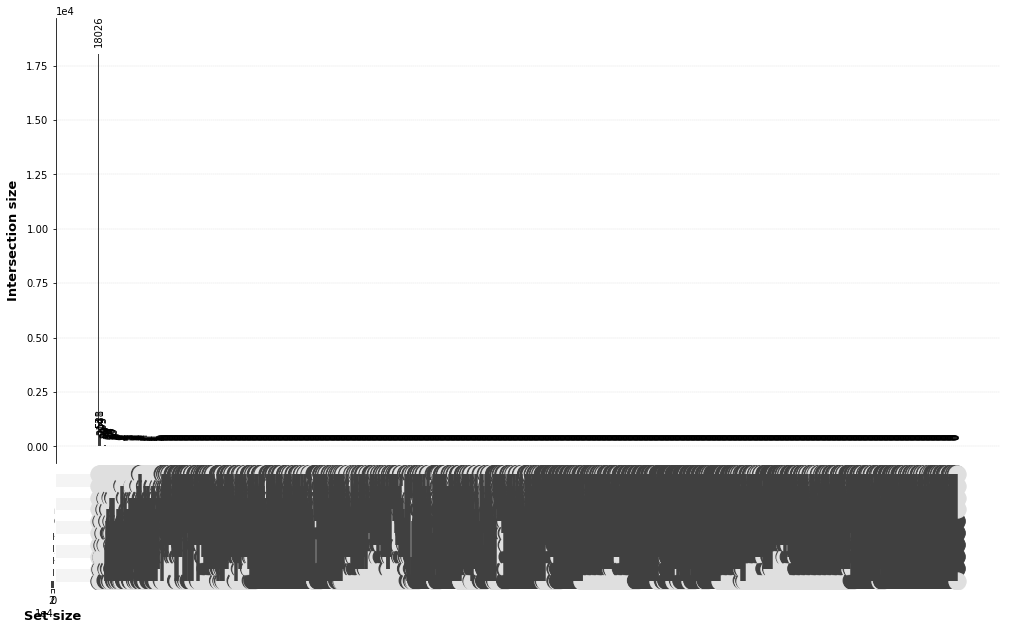

In [48]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(success_by_source, column_names=['gene', 'phenotype'])


## Finding gene-PMID associations and comparing to gene-phenotype

This is some debugging code for issue 41: https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41

In [50]:
double_listed_refs = Counter()
single_listed_refs = Counter()

listed_evidence = Counter()
single_evidence = Counter()
for hit in res['hits']['hits']:
    if isinstance(hit['_source']['association']['evidence'], list):
        listed_evidence[hit['_source']['source']] += 1
        for evidence in hit['_source']['association']['evidence']:
            for pmid_url in evidence['info']['publications']:
                if isinstance(pmid_url, list):
                    double_listed_refs[hit['_source']['source']] += 1
                else:
                    single_listed_refs[hit['_source']['source']] += 1
    else:
        single_evidence[hit['_source']['source']] += 1
        evidence = hit['_source']['association']['evidence']
        for pmid_url in evidence['info']['publications']:
            if isinstance(pmid_url, list):
                double_listed_refs[hit['_source']['source']] += 1
            else:
                single_listed_refs[hit['_source']['source']] += 1

TypeError: 'NoneType' object has no attribute '__getitem__'

In [51]:
print(double_listed_refs)
print(single_listed_refs)
print(listed_evidence)
print(single_evidence)

Counter()
Counter({u'jax': 728, u'civic': 675, u'pmkb': 626, u'cgi': 378, u'oncokb': 72, u'sage': 20})
Counter({u'jax': 745, u'civic': 675, u'cgi': 280, u'pmkb': 110, u'oncokb': 44, u'sage': 20, u'brca': 1})
Counter()


First, we'll look at just PMID overlap

In [52]:
pmid_re = re.compile(r'https?://www.ncbi.nlm.nih.gov/pubmed/(\d+)')
source_pmids = defaultdict(set)
single_url = Counter()
listed_url = Counter()
for hit in res['hits']['hits']:
    pmids = set()
    # next two lines fix double_listing, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
    if not isinstance(hit['_source']['association']['evidence'], list):
        hit['_source']['association']['evidence'] = [hit['_source']['association']['evidence']]
    for evidence in hit['_source']['association']['evidence']:
        urls = evidence['info']['publications']
    # next two lines fix single_evidence, see https://github.com/ohsu-comp-bio/g2p-aggregator/issues/41
        if urls and isinstance(urls[0], list):
            urls = itertools.chain.from_iterable(urls)
        for pmid_url in urls:
            match = pmid_re.match(pmid_url)
            if match:
                pmids.add(match.groups()[0])
    urls = hit['_source']['association'].get('publication_url')
    # the following lines document differences in the structure of the publication_url field
    if not isinstance(urls, list):
        single_url[hit['_source']['source']] += 1
        urls = [urls]
    else:
        listed_url[hit['_source']['source']] += 1
    for url in urls:
        if url is None:
            continue
        match = pmid_re.match(url)
        if match:
            pmids.add(match.groups()[0])
    source_pmids[hit['_source']['source']] |= pmids
    pmids = list(pmids)
    if 'merged' in hit:
        hit['merged']['pmids'] = pmids
    else:
        hit['merged'] = {'pmids': pmids}
    

TypeError: 'NoneType' object has no attribute '__getitem__'

In [53]:
{k: len(v) for k, v in source_pmids.items()}

{u'cgi': 212,
 u'civic': 505,
 u'jax': 366,
 u'oncokb': 55,
 u'pmkb': 179,
 u'sage': 17}

In [54]:
overlap(source_pmids)

cgi has 22/212 (0.00%) overlap with jax
cgi has 32/212 (0.00%) overlap with civic
cgi has 7/212 (0.00%) overlap with sage
cgi has 0/212 (0.00%) overlap with oncokb
cgi has 0/212 (0.00%) overlap with pmkb
cgi has 56/212 (0.00%) overlap overall
jax has 22/366 (0.00%) overlap with cgi
jax has 31/366 (0.00%) overlap with civic
jax has 0/366 (0.00%) overlap with sage
jax has 3/366 (0.00%) overlap with oncokb
jax has 4/366 (0.00%) overlap with pmkb
jax has 53/366 (0.00%) overlap overall
civic has 32/505 (0.00%) overlap with cgi
civic has 31/505 (0.00%) overlap with jax
civic has 0/505 (0.00%) overlap with sage
civic has 0/505 (0.00%) overlap with oncokb
civic has 10/505 (0.00%) overlap with pmkb
civic has 66/505 (0.00%) overlap overall
sage has 7/17 (0.00%) overlap with cgi
sage has 0/17 (0.00%) overlap with jax
sage has 0/17 (0.00%) overlap with civic
sage has 0/17 (0.00%) overlap with oncokb
sage has 0/17 (0.00%) overlap with pmkb
sage has 7/17 (0.00%) overlap overall
oncokb has 0/55 (0.00

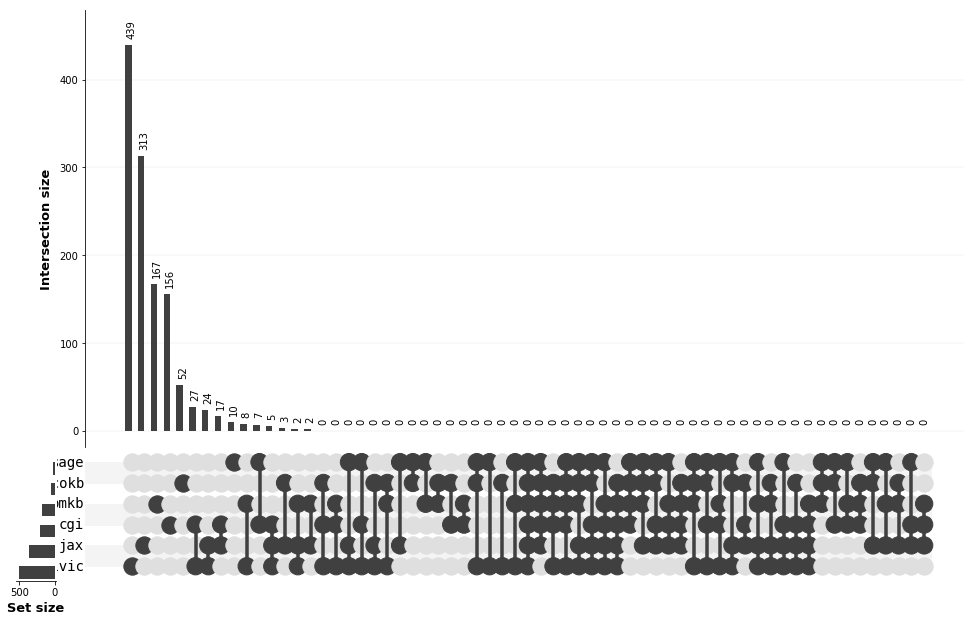

In [55]:
def plot_overlap(d, column_names=['attribute']):
    d2 = {g: pd.DataFrame(list(d[g]), columns=column_names) for g in d}
    pyu.plot(d2, unique_keys = column_names)
    
plot_overlap(source_pmids)

Parse PMIDs specifically for each source, see if differences exist.

Connect PMIDs to genes, phenotypes, gene + phenotype

In [56]:
pmid_dict = defaultdict(lambda: defaultdict(list))
for hit in res['hits']['hits']:
    pmids = hit.get('merged',{}).get('pmids',[])
    for pmid in pmids:
        pmid_dict[pmid][hit['_source']['source']].append(hit['merged'])

In [57]:
len(pmid_dict)

1232

In [58]:
multi_hit_pmids = {x: v for x, v in pmid_dict.items() if len(v) > 1}
len(multi_hit_pmids)

95

In [59]:
multi_hit_pmids['24569458']

KeyError: '24569458'

In [60]:
multi_hit_normalized = dict()
for pmid, source_dict in multi_hit_pmids.items():
    new_source_dict = dict()
    for source, associations in source_dict.items():
        filtered_associations = [x for x in associations if 'phenotype' in x]
        if any(filtered_associations):
            new_source_dict[source] = filtered_associations
    if len(new_source_dict) > 1:
        multi_hit_normalized[pmid] = new_source_dict
len(multi_hit_normalized)

92

In [61]:
def g_p_associations(associations):
    new_assoc = list()
    for association in associations:
        new_assoc.append((association['gene'], association['phenotype']))
    return set(new_assoc)

source_pairs = Counter()
pair_complete_matches = Counter()
pair_partial_matches = Counter()
pair_no_matches = Counter()
for pmid, source_dict in multi_hit_normalized.items():
    sources = sorted(source_dict)
    for i, source in enumerate(sources, start=1):
        for j in range(i, len(sources)):
            source2 = sources[j]
            source_pairs[(source, source2)] += 1
            source_gp_assoc = g_p_associations(source_dict[source])
            source2_gp_assoc = g_p_associations(source_dict[source2])
            if source_gp_assoc == source2_gp_assoc:
                pair_complete_matches[(source, source2)] += 1
            elif any(source_gp_assoc & source2_gp_assoc):
                pair_partial_matches[(source, source2)] += 1
            else:
                pair_no_matches[(source, source2)] += 1
                print("=====\n{}: {}\n{}: {}".format(source, source_gp_assoc, source2, source2_gp_assoc))

=====
jax: set([(u'E|F|G|R', u'DOID:3908')])
pmkb: set([(u'EGFR', u'DOID:299'), (u'EGFR', u'DOID:3908')])
=====
civic: set([(u'AKT1', u'DOID:162')])
jax: set([(u'1|A|K|T', u'DOID:2999')])
=====
cgi: set([(u'ESR1', u'DOID:3458')])
civic: set([(u'ESR1', u'DOID:1612')])
=====
cgi: set([(u'KIT', u'DOID:8923')])
jax: set([(u'I|K|T', u'DOID:1909')])
=====
civic: set([(u'ERBB3', u'DOID:7244')])
jax: set([(u',|2|B|B|E|E|F|G|R|R', u'DOID:11054'), (u'2|B|B|E|R', u'DOID:11054')])
=====
civic: set([(u'KRAS', u'DOID:9256')])
pmkb: set([(u'KRAS', u'DOID:299')])
=====
cgi: set([(u'NRAS', u'DOID:9119')])
civic: set([(u'NRAS', u'DOID:1324'), (u'NRAS', u'DOID:3908')])
=====
civic: set([(u'KRAS', u'DOID:9256')])
pmkb: set([(u'KRAS', u'DOID:299')])
=====
cgi: set([(u'BRAF', u'DOID:0050861')])
civic: set([(u'GNAS', u'DOID:9256')])
=====
civic: set([(u'KRAS', u'DOID:9256')])
pmkb: set([(u'KRAS', u'DOID:299')])
=====
cgi: set([(u'BRAF', u'DOID:3910')])
civic: set([(u'BRAF', u'DOID:1909')])
=====
cgi: set([(u

In [62]:
print(pair_complete_matches)
print(pair_partial_matches)
print(pair_no_matches)

Counter({(u'cgi', u'sage'): 5, (u'cgi', u'civic'): 3})
Counter({(u'cgi', u'civic'): 1})
Counter({(u'civic', u'jax'): 31, (u'cgi', u'civic'): 27, (u'cgi', u'jax'): 21, (u'civic', u'pmkb'): 10, (u'jax', u'pmkb'): 4, (u'cgi', u'sage'): 2, (u'jax', u'oncokb'): 2})
